# Text Classification

* [Kaggle Link for Code](https://www.kaggle.com/dikshabhati2002/text-classification-lstm-bert-ml-models/notebook)

#### Table of Contents:
- [Read in Data](#read_in_data)

In [27]:
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from time import time
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn.metrics import accuracy_score, precision_score, recall_score, plot_confusion_matrix, confusion_matrix, f1_score
from statistics import mean
import pickle
from tensorflow import keras
from tensorflow.keras.models import load_model
import torch
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import utils
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional, Dropout
from tqdm import tqdm as tq
import time
for i in tq(range(20), desc = 'tq() ### Library Importing Is Complete. ###'):
    time.sleep(0.5)

print('#####  IMPORTS COMPLETE  #####')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\proto\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\proto\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\proto\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\omw-1.4.zip.
tq() ### Library Importing Is Complete. ###: 100%|██████████| 20/20 [00:10<00:00,  1.95it/s]

#####  IMPORTS COMPLETE  #####


## Read in Data into Dataframe
<a id='read_in_data'></a>

In [3]:
dataset = fetch_20newsgroups(subset ='train', 
                             remove=('headers', 'footers', 'quotes'), 
                             shuffle=True, 
                             random_state=42)

df = pd.DataFrame()
df['text'] = dataset.data
df['source'] = dataset.target

label = []

for i in df['source']:
    label.append(dataset.target_names[i])

df['label']=label

In [4]:
df.head(5)

,text,source,label
0,I was wondering if anyone out there could enli...,7,rec.autos
1,A fair number of brave souls who upgraded thei...,4,comp.sys.mac.hardware
2,"well folks, my mac plus finally gave up the gh...",4,comp.sys.mac.hardware
3,\nDo you have Weitek's address/phone number? ...,1,comp.graphics
4,"From article <C5owCB.n3p@world.std.com>, by to...",14,sci.space


In [5]:
# Remove source feature as label will be encoded for dependant:
df.drop(['source'], axis = 1, inplace = True)
df.info()
df['label'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11314 entries, 0 to 11313
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11314 non-null  object
 1   label   11314 non-null  object
dtypes: object(2)
memory usage: 176.9+ KB


rec.sport.hockey            600
soc.religion.christian      599
rec.motorcycles             598
rec.sport.baseball          597
sci.crypt                   595
rec.autos                   594
sci.med                     594
comp.windows.x              593
sci.space                   593
comp.os.ms-windows.misc     591
sci.electronics             591
comp.sys.ibm.pc.hardware    590
misc.forsale                585
comp.graphics               584
comp.sys.mac.hardware       578
talk.politics.mideast       564
talk.politics.guns          546
alt.atheism                 480
talk.politics.misc          465
talk.religion.misc          377
Name: label, dtype: int64

In [6]:
# replace to politics
df['label'].replace({'talk.politics.misc':'politics','talk.politics.guns':'politics',
                     'talk.politics.mideast':'politics'}, inplace=True)
                    
# replace to sport
df['label'].replace({'rec.sport.hockey':'sport','rec.sport.baseball':'sport'}, inplace=True)
                    
# replace to religion
df['label'].replace({'soc.religion.christian':'religion','talk.religion.misc':'religion'}, inplace=True)
                    
# replace to computer
df['label'].replace({'comp.windows.x':'computer','comp.sys.ibm.pc.hardware':'computer',
                    'comp.os.ms-windows.misc':'computer','comp.graphics':'computer',
                    'comp.sys.mac.hardware':'computer'}, inplace=True)  
# replace to sales
df['label'].replace({'misc.forsale':'sales'}, inplace=True)

# replace to automobile
df['label'].replace({'rec.autos':'automobile','rec.motorcycles':'automobile'}, inplace=True)

# replace to science
df['label'].replace({'sci.crypt':'science','sci.electronics':'science','sci.space':'science'}, inplace=True)

# replace to medicine
df['label'].replace({'sci.med':'medicine'}, inplace=True)

In [7]:
# Value counts for labeled features:
df['label'].value_counts()

computer       2936
science        1779
politics       1575
sport          1197
automobile     1192
religion        976
medicine        594
sales           585
alt.atheism     480
Name: label, dtype: int64

In [8]:
# Apply word count on text data:
df['Number_of_words'] = df['text'].apply(lambda x:len(str(x).split()))
df.head()

,text,label,Number_of_words
0,I was wondering if anyone out there could enli...,automobile,91
1,A fair number of brave souls who upgraded thei...,computer,90
2,"well folks, my mac plus finally gave up the gh...",computer,307
3,\nDo you have Weitek's address/phone number? ...,computer,15
4,"From article <C5owCB.n3p@world.std.com>, by to...",science,72


In [9]:
# Number of words stats:
df['Number_of_words'].describe()

count    11314.000000
mean       185.827382
std        523.971647
min          0.000000
25%         40.000000
50%         83.000000
75%        167.000000
max      11765.000000
Name: Number_of_words, dtype: float64

In [10]:
# Drop all words that equal 0:
no_text = df[df['Number_of_words']==0]
print(len(no_text))

# drop these rows
df.drop(no_text.index,inplace=True)

300


C:\Program Files\DS_and_SD_ALL\Python_Env\Python3.9.8\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Frequency distribution of number of words for each text extracted')

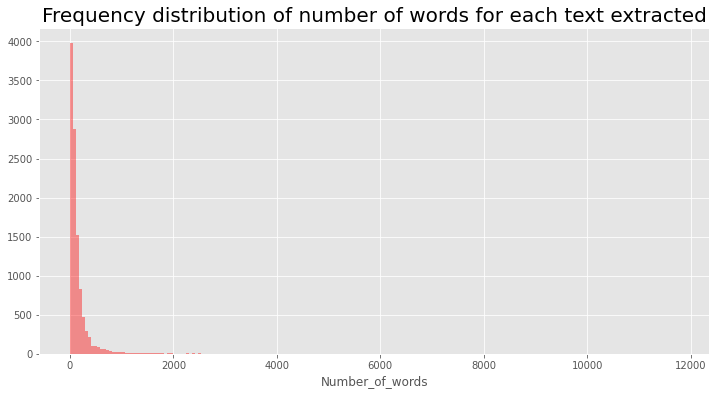

In [11]:
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
sns.distplot(df['Number_of_words'],kde = False,color="red",bins=200)
plt.title("Frequency distribution of number of words for each text extracted", size=20)

## NLP Pre-Processing Stages
- Text Cleaning (i.e. text lowercase, remove links, remove punctuation)
- Tokenize
- Remove Stopwords
- Lemmatization
- Combine Text (combines lemmatized text into a la chunk) 

In [12]:
# cleaning the text:

def clean_text(text):

    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

# Applying the cleaning function to  datasets
df['cleaned_text'] = df['text'].apply(lambda x: clean_text(x))

# updated text
df['cleaned_text'].head()

0    i was wondering if anyone out there could enli...
1    a fair number of brave souls who upgraded thei...
2    well folks my mac plus finally gave up the gho...
3    do you have weiteks addressphone number  id li...
4    from article  by tombakerworldstdcom tom a bak...
Name: cleaned_text, dtype: object

## Tokenize the Cleaned Text Features

In [14]:
df.head(1)

,text,label,Number_of_words,cleaned_text
0,I was wondering if anyone out there could enli...,automobile,91,i was wondering if anyone out there could enli...


In [13]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

Downloading: 100%|██████████| 690/690 [00:00<00:00, 341kB/s]
Downloading: 100%|██████████| 3.69k/3.69k [00:00<00:00, 1.23MB/s]
Downloading: 100%|██████████| 229/229 [00:00<00:00, 115kB/s]
Downloading: 100%|██████████| 90.9M/90.9M [00:03<00:00, 29.9MB/s]
Downloading: 100%|██████████| 53.0/53.0 [00:00<00:00, 26.9kB/s]
Downloading: 100%|██████████| 112/112 [00:00<00:00, 56.2kB/s]
Downloading: 100%|██████████| 466k/466k [00:00<00:00, 2.97MB/s]
Downloading: 100%|██████████| 314/314 [00:00<00:00, 106kB/s]
Downloading: 100%|██████████| 232k/232k [00:00<00:00, 1.75MB/s]
Downloading: 100%|██████████| 190/190 [00:00<00:00, 47.5kB/s]


In [17]:
df['Embeddings'] = df['cleaned_text'].apply(lambda x: model.encode(x))

In [19]:
df.head()

,text,label,Number_of_words,cleaned_text,Embeddings
0,I was wondering if anyone out there could enli...,automobile,91,i was wondering if anyone out there could enli...,"[-0.2169023, 0.3787161, -0.07648176, -0.114474..."
1,A fair number of brave souls who upgraded thei...,computer,90,a fair number of brave souls who upgraded thei...,"[-0.30095673, 0.18353896, 0.12806539, -0.11697..."
2,"well folks, my mac plus finally gave up the gh...",computer,307,well folks my mac plus finally gave up the gho...,"[-0.52718556, -0.11658931, 0.084600456, 0.0283..."
3,\nDo you have Weitek's address/phone number? ...,computer,15,do you have weiteks addressphone number id li...,"[-0.733039, -0.067057244, -0.14722012, -0.0828..."
4,"From article <C5owCB.n3p@world.std.com>, by to...",science,72,from article by tombakerworldstdcom tom a bak...,"[-0.42001218, -0.40443245, -0.039418466, -0.18..."


In [20]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

df['tokens'] = df['cleaned_text'].apply(lambda x:tokenizer.tokenize(x))

,text,label,Number_of_words,cleaned_text,Embeddings,tokens
0,I was wondering if anyone out there could enli...,automobile,91,i was wondering if anyone out there could enli...,"[-0.2169023, 0.3787161, -0.07648176, -0.114474...","[i, was, wondering, if, anyone, out, there, co..."
1,A fair number of brave souls who upgraded thei...,computer,90,a fair number of brave souls who upgraded thei...,"[-0.30095673, 0.18353896, 0.12806539, -0.11697...","[a, fair, number, of, brave, souls, who, upgra..."
2,"well folks, my mac plus finally gave up the gh...",computer,307,well folks my mac plus finally gave up the gho...,"[-0.52718556, -0.11658931, 0.084600456, 0.0283...","[well, folks, my, mac, plus, finally, gave, up..."
3,\nDo you have Weitek's address/phone number? ...,computer,15,do you have weiteks addressphone number id li...,"[-0.733039, -0.067057244, -0.14722012, -0.0828...","[do, you, have, weiteks, addressphone, number,..."
4,"From article <C5owCB.n3p@world.std.com>, by to...",science,72,from article by tombakerworldstdcom tom a bak...,"[-0.42001218, -0.40443245, -0.039418466, -0.18...","[from, article, by, tombakerworldstdcom, tom, ..."


## Removing Stopwords within Tokeized Feature

In [23]:
# removing stopwords
def remove_stopwords(text):

    words = [w for w in text if w not in stopwords.words('english')]
    return words
    
df['stopwordremove_tokens'] = df['tokens'].apply(lambda x : remove_stopwords(x))

,text,label,Number_of_words,cleaned_text,Embeddings,tokens,stopwordremove_tokens
0,I was wondering if anyone out there could enli...,automobile,91,i was wondering if anyone out there could enli...,"[-0.2169023, 0.3787161, -0.07648176, -0.114474...","[i, was, wondering, if, anyone, out, there, co...","[wondering, anyone, could, enlighten, car, saw..."
1,A fair number of brave souls who upgraded thei...,computer,90,a fair number of brave souls who upgraded thei...,"[-0.30095673, 0.18353896, 0.12806539, -0.11697...","[a, fair, number, of, brave, souls, who, upgra...","[fair, number, brave, souls, upgraded, si, clo..."
2,"well folks, my mac plus finally gave up the gh...",computer,307,well folks my mac plus finally gave up the gho...,"[-0.52718556, -0.11658931, 0.084600456, 0.0283...","[well, folks, my, mac, plus, finally, gave, up...","[well, folks, mac, plus, finally, gave, ghost,..."
3,\nDo you have Weitek's address/phone number? ...,computer,15,do you have weiteks addressphone number id li...,"[-0.733039, -0.067057244, -0.14722012, -0.0828...","[do, you, have, weiteks, addressphone, number,...","[weiteks, addressphone, number, id, like, get,..."
4,"From article <C5owCB.n3p@world.std.com>, by to...",science,72,from article by tombakerworldstdcom tom a bak...,"[-0.42001218, -0.40443245, -0.039418466, -0.18...","[from, article, by, tombakerworldstdcom, tom, ...","[article, tombakerworldstdcom, tom, bakermy, u..."


## Lemmatization of Tokenized Feature with Stopwords Removed

In [28]:
# lemmatization:
lem = WordNetLemmatizer()

def lem_word(x):
    return [lem.lemmatize(w) for w in x]

df['lemmatized_text'] = df['stopwordremove_tokens'].apply(lem_word)

## Combine Text into Large Chunk into a Feature

In [29]:
def combine_text(list_of_text):

    '''Takes a list of text and combines them into one large chunk of text.'''
    
    combined_text = ' '.join(list_of_text)
    return combined_text

df['final_text'] = df['lemmatized_text'].apply(lambda x : combine_text(x))

In [30]:
df['Final_no_of_words'] = df['final_text'].apply(lambda x:len(str(x).split()))

In [32]:
# basic stats
df['Final_no_of_words'].describe()

count    11014.000000
mean        93.284547
std        269.498465
min          0.000000
25%         21.000000
50%         42.000000
75%         83.000000
max       6433.000000
Name: Final_no_of_words, dtype: float64

In [33]:
# number of rows with text lenth = 0
print(len(df[df['Final_no_of_words']==0]))

# drop those rows
df.drop(df[df['Final_no_of_words']==0].index,inplace=True)

20


## LabelEncode the "Label" Feature and Assing to New Feature "Target"
- This method classifies the text into a binary format for processing into a ML model:

In [34]:
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'species'.
df['target']= label_encoder.fit_transform(df['label'])
  
df['target'].unique()

array([1, 2, 7, 4, 3, 5, 6, 0, 8])

In [35]:
df.head()

,text,label,Number_of_words,cleaned_text,Embeddings,tokens,stopwordremove_tokens,lemmatized_text,final_text,Final_no_of_words,target
0,I was wondering if anyone out there could enli...,automobile,91,i was wondering if anyone out there could enli...,"[-0.2169023, 0.3787161, -0.07648176, -0.114474...","[i, was, wondering, if, anyone, out, there, co...","[wondering, anyone, could, enlighten, car, saw...","[wondering, anyone, could, enlighten, car, saw...",wondering anyone could enlighten car sawthe da...,42,1
1,A fair number of brave souls who upgraded thei...,computer,90,a fair number of brave souls who upgraded thei...,"[-0.30095673, 0.18353896, 0.12806539, -0.11697...","[a, fair, number, of, brave, souls, who, upgra...","[fair, number, brave, souls, upgraded, si, clo...","[fair, number, brave, soul, upgraded, si, cloc...",fair number brave soul upgraded si clock oscil...,52,2
2,"well folks, my mac plus finally gave up the gh...",computer,307,well folks my mac plus finally gave up the gho...,"[-0.52718556, -0.11658931, 0.084600456, 0.0283...","[well, folks, my, mac, plus, finally, gave, up...","[well, folks, mac, plus, finally, gave, ghost,...","[well, folk, mac, plus, finally, gave, ghost, ...",well folk mac plus finally gave ghost weekend ...,149,2
3,\nDo you have Weitek's address/phone number? ...,computer,15,do you have weiteks addressphone number id li...,"[-0.733039, -0.067057244, -0.14722012, -0.0828...","[do, you, have, weiteks, addressphone, number,...","[weiteks, addressphone, number, id, like, get,...","[weiteks, addressphone, number, id, like, get,...",weiteks addressphone number id like get inform...,8,2
4,"From article <C5owCB.n3p@world.std.com>, by to...",science,72,from article by tombakerworldstdcom tom a bak...,"[-0.42001218, -0.40443245, -0.039418466, -0.18...","[from, article, by, tombakerworldstdcom, tom, ...","[article, tombakerworldstdcom, tom, bakermy, u...","[article, tombakerworldstdcom, tom, bakermy, u...",article tombakerworldstdcom tom bakermy unders...,35,7


In [37]:
# Export pre-prossed data to csv:
df.to_csv(r'C:\ds_dev\text_preprossed_data.csv', index = False, encoding = 'utf-8')

## Assign X (Dependant) and y (Independant) Variables

In [38]:
# dependent and independent variable
X = df['final_text']
y = df['target']

# View shape of variables
X.shape, y.shape

((10994,), (10994,))

## CountVectorize

In [39]:
count_vectorizer = CountVectorizer()
count_vector = count_vectorizer.fit_transform(X)
print(count_vector[0].todense())

[[0 0 0 ... 0 0 0]]


## Tf-Idf (Term-Frequency-Inverse Document Freguency)

In [40]:
tfidf_vectorizer = TfidfVectorizer(min_df = 2,max_df = 0.5,ngram_range = (1,2))
tfidf = tfidf_vectorizer.fit_transform(X)
print(tfidf[0].todense())

[[0. 0. 0. ... 0. 0. 0.]]


## SMOTE the dataset for minimizing oversampling:

### SMOTE the CountVectorized data

C:\Program Files\DS_and_SD_ALL\Python_Env\Python3.9.8\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='target', ylabel='count'>

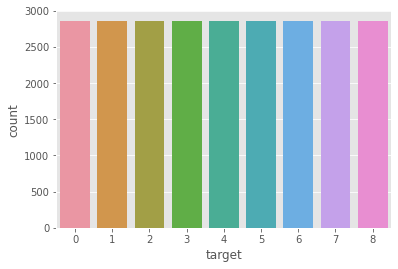

In [41]:
# count vector
smote = SMOTE(random_state = 402)
X_smote, Y_smote = smote.fit_resample(count_vector,y)


sns.countplot(Y_smote)

### SMOTE the Tf-Idf data

C:\Program Files\DS_and_SD_ALL\Python_Env\Python3.9.8\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='target', ylabel='count'>

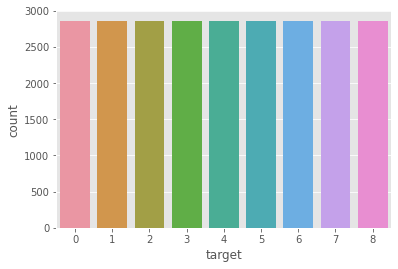

In [42]:
# tfidf
smote = SMOTE(random_state = 402)
X_smote_tfidf, Y_smote_tfidf = smote.fit_resample(tfidf,y)

sns.countplot(Y_smote_tfidf)

## Split Processed Data into Train/Test
- Will split the train/test into the various SMOTE data variables

In [43]:
# train-test split countvector
X_train, X_test, y_train, y_test = train_test_split(X_smote, Y_smote, test_size = 0.20, random_state = 0)

# train-test split tfidf
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_smote_tfidf, Y_smote_tfidf , test_size = 0.20, random_state = 0)

In [44]:
training_time_container = {'linear_svm_tfidf':0,'linear_svm':0,'mnb_naive_bayes_tfidf':0,
                         'mnb_naive_bayes':0,'random_forest_tfidf':0,'random_forest':0,
                          'logistic_reg':0,'logistic_reg_tfidf':0}

prediction_time_container = {'linear_svm_tfidf':0,'linear_svm':0,'mnb_naive_bayes_tfidf':0,
                         'mnb_naive_bayes':0,'random_forest_tfidf':0,'random_forest':0,
                            'logistic_reg':0,'logistic_reg_tfidf':0}
                            
accuracy_container = {'linear_svm_tfidf':0,'linear_svm':0,'mnb_naive_bayes_tfidf':0,
                         'mnb_naive_bayes':0,'random_forest_tfidf':0,'random_forest':0,
                     'logistic_reg':0,'logistic_reg_tfidf':0}

## Logistic Regression Model on Tf-Idf

In [45]:
from time import time

# on countvector
lg = LogisticRegression(C = 1.0, max_iter = 1)
#Fitting the model 
t0 = time()
lg.fit(X_train_tfidf,y_train_tfidf)
training_time_container['logistic_reg']=time()-t0


# Predicting the Test set results
t0 = time()
y_pred_lg = lg.predict(X_test_tfidf)
prediction_time_container['logistic_reg']=time()-t0

lg_test_accuracy =  accuracy_score(y_test_tfidf,y_pred_lg)
accuracy_container['logistic_reg'] = lg_test_accuracy

print('Training Accuracy : ', accuracy_score(y_train_tfidf,lg.predict(X_train_tfidf)))
print('Testing Accuracy: ',lg_test_accuracy)
print("Training Time: ",training_time_container['logistic_reg'])
print("Prediction Time: ",prediction_time_container['logistic_reg'])
print(confusion_matrix(y_test_tfidf,y_pred_lg))

Training Accuracy :  0.219733773804897
Testing Accuracy:  0.20419661938993589
Training Time:  3.003610849380493
Prediction Time:  0.027566909790039062
[[ 69   0 422   0   3  95   0   0   0]
 [  0  11 560   0   0   0   0   0   0]
 [  0   0 533   0   0   0   0   0   0]
 [  0   0 456 113   0   0   0   0   0]
 [  0   0 466   0  89   1   0   0   0]
 [  0   0 325   0   2 233   0   0   0]
 [  0   0 589   0   0   0   2   0   0]
 [  0   0 577   0   3   0   0   1   0]
 [  0   0 597   0   0   0   0   0   0]]


C:\Program Files\DS_and_SD_ALL\Python_Env\Python3.9.8\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# count vector
smote = SMOTE(random_state = 402)
X_smote, Y_smote = smote.fit_resample(Embeddings,y)


sns.countplot(Y_smote)